## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ['CUDA_VISIBLE_DEVICES']= ''

Using TensorFlow backend.
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\user\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True): # 可以選擇要不要flatten，預設是要
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y

In [4]:
# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preproc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1, l2, l1_l2

def build_mlp(input_shape, regularizer, output_units=10, num_neurons=[512, 256, 128], l1_ratio=1e-4, l2_ratio=1e-4):
    if regularizer == 'l1':
        reg = l1(l1_ratio)
    elif regularizer == 'l2':
        reg = l2(l2_ratio)
    elif regularizer == 'l1_l2':
        reg = l1_l2(l1=l1_ratio, l2=l2_ratio)
    
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer%d'%(i+1), 
                                   kernel_regularizer=reg)(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation='relu', 
                                   name='hidden_layer%d'%(i+1), 
                                   kernel_regularizer=reg)(x)
    
    output_layer = keras.layers.Dense(units=output_units, activation='softmax', name='output_layer')(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[output_layer])
    return model

In [6]:
# Hyperparameters
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [1e-2, 1e-4]
L2_EXP = [1e-2, 1e-4]

In [8]:
results = {}
# L1, L2, L1_L2
for reg in ['l1', 'l2', 'l1_l2']:
    for (i, j) in zip(L1_EXP, L2_EXP):
        keras.backend.clear_session()
        print('Experiment with regularizer %s, reg_ratio %f'%(reg, i))
        
        model = build_mlp(input_shape=x_train.shape[1:], regularizer=reg, l1_ratio=i, l2_ratio=j)
        model.summary()

        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
        model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        model.fit(x_train, y_train,
                 epochs=EPOCHS,
                 batch_size=BATCH_SIZE,
                 validation_data=(x_test, y_test),
                 shuffle=True)
        
        # collect results
        exp_name_tag = 'reg %s ratio %f'%(reg, i)
        results[exp_name_tag] = {'train_loss': model.history.history['loss'],
                                'valid_loss': model.history.history['val_loss'],
                                'train_acc': model.history.history['accuracy'],
                                'valid_acc': model.history.history['val_accuracy']}

Experiment with regularizer l1, reg_ratio 0.010000
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output_layer (Dense)         (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/50
500

50000/50000 [==============================] - 39s 776us/step - loss: 2.4626 - accuracy: 0.0967 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 49/50
50000/50000 [==============================] - 39s 783us/step - loss: 2.4626 - accuracy: 0.0983 - val_loss: 2.4626 - val_accuracy: 0.1000
Epoch 50/50
50000/50000 [==============================] - 39s 780us/step - loss: 2.4626 - accuracy: 0.0992 - val_loss: 2.4626 - val_accuracy: 0.1000
Experiment with regularizer l1, reg_ratio 0.000100
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
________________________________

50000/50000 [==============================] - 39s 777us/step - loss: 2.8309 - accuracy: 0.6181 - val_loss: 3.0835 - val_accuracy: 0.5251
Epoch 46/50
50000/50000 [==============================] - 39s 776us/step - loss: 2.7912 - accuracy: 0.6213 - val_loss: 3.1218 - val_accuracy: 0.5147
Epoch 47/50
50000/50000 [==============================] - 39s 780us/step - loss: 2.7508 - accuracy: 0.6249 - val_loss: 2.9999 - val_accuracy: 0.5392
Epoch 48/50
50000/50000 [==============================] - 39s 775us/step - loss: 2.7113 - accuracy: 0.6267 - val_loss: 3.0075 - val_accuracy: 0.5172
Epoch 49/50
50000/50000 [==============================] - 40s 807us/step - loss: 2.6695 - accuracy: 0.6294 - val_loss: 2.9104 - val_accuracy: 0.5400
Epoch 50/50
50000/50000 [==============================] - 40s 807us/step - loss: 2.6352 - accuracy: 0.6303 - val_loss: 2.9501 - val_accuracy: 0.5266
Experiment with regularizer l2, reg_ratio 0.010000
Model: "model_1"
____________________________________________

50000/50000 [==============================] - 39s 778us/step - loss: 1.6454 - accuracy: 0.5145 - val_loss: 1.6859 - val_accuracy: 0.4993
Epoch 43/50
50000/50000 [==============================] - 38s 764us/step - loss: 1.6406 - accuracy: 0.5149 - val_loss: 1.7305 - val_accuracy: 0.4818
Epoch 44/50
50000/50000 [==============================] - 39s 781us/step - loss: 1.6362 - accuracy: 0.5159 - val_loss: 1.7114 - val_accuracy: 0.4800
Epoch 45/50
50000/50000 [==============================] - 39s 786us/step - loss: 1.6312 - accuracy: 0.5182 - val_loss: 1.7230 - val_accuracy: 0.4814
Epoch 46/50
50000/50000 [==============================] - 39s 781us/step - loss: 1.6273 - accuracy: 0.5174 - val_loss: 1.6716 - val_accuracy: 0.5007
Epoch 47/50
50000/50000 [==============================] - 38s 766us/step - loss: 1.6224 - accuracy: 0.5212 - val_loss: 1.6923 - val_accuracy: 0.4937
Epoch 48/50
50000/50000 [==============================] - 39s 774us/step - loss: 1.6180 - accuracy: 0.5205 - va

50000/50000 [==============================] - 39s 780us/step - loss: 1.1614 - accuracy: 0.6414 - val_loss: 1.4828 - val_accuracy: 0.5298
Epoch 40/50
50000/50000 [==============================] - 39s 770us/step - loss: 1.1468 - accuracy: 0.6449 - val_loss: 1.4773 - val_accuracy: 0.5332
Epoch 41/50
50000/50000 [==============================] - 40s 793us/step - loss: 1.1347 - accuracy: 0.6505 - val_loss: 1.4892 - val_accuracy: 0.5329
Epoch 42/50
50000/50000 [==============================] - 39s 784us/step - loss: 1.1251 - accuracy: 0.6540 - val_loss: 1.4943 - val_accuracy: 0.5274
Epoch 43/50
50000/50000 [==============================] - 39s 777us/step - loss: 1.1142 - accuracy: 0.6588 - val_loss: 1.5365 - val_accuracy: 0.5297
Epoch 44/50
50000/50000 [==============================] - 38s 766us/step - loss: 1.1008 - accuracy: 0.6629 - val_loss: 1.5724 - val_accuracy: 0.5106
Epoch 45/50
50000/50000 [==============================] - 40s 795us/step - loss: 1.0902 - accuracy: 0.6672 - va

50000/50000 [==============================] - 42s 831us/step - loss: 2.4617 - accuracy: 0.0975 - val_loss: 2.4618 - val_accuracy: 0.1000
Epoch 37/50
50000/50000 [==============================] - 41s 810us/step - loss: 2.4617 - accuracy: 0.0985 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 38/50
50000/50000 [==============================] - 41s 817us/step - loss: 2.4617 - accuracy: 0.0970 - val_loss: 2.4617 - val_accuracy: 0.1000
Epoch 39/50
50000/50000 [==============================] - 42s 843us/step - loss: 2.4616 - accuracy: 0.0957 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 40/50
50000/50000 [==============================] - 41s 829us/step - loss: 2.4616 - accuracy: 0.0977 - val_loss: 2.4616 - val_accuracy: 0.1000
Epoch 41/50
50000/50000 [==============================] - 41s 824us/step - loss: 2.4616 - accuracy: 0.0988 - val_loss: 2.4617 - val_accuracy: 0.1000
Epoch 42/50
50000/50000 [==============================] - 41s 819us/step - loss: 2.4616 - accuracy: 0.0962 - va

50000/50000 [==============================] - 46s 916us/step - loss: 3.3746 - accuracy: 0.5932 - val_loss: 3.5265 - val_accuracy: 0.5240
Epoch 34/50
50000/50000 [==============================] - 41s 824us/step - loss: 3.3219 - accuracy: 0.5968 - val_loss: 3.4888 - val_accuracy: 0.5190
Epoch 35/50
50000/50000 [==============================] - 41s 823us/step - loss: 3.2692 - accuracy: 0.5958 - val_loss: 3.4363 - val_accuracy: 0.5239
Epoch 36/50
50000/50000 [==============================] - 41s 812us/step - loss: 3.2168 - accuracy: 0.5992 - val_loss: 3.3739 - val_accuracy: 0.5295
Epoch 37/50
50000/50000 [==============================] - 40s 808us/step - loss: 3.1651 - accuracy: 0.6016 - val_loss: 3.3876 - val_accuracy: 0.5116
Epoch 38/50
50000/50000 [==============================] - 42s 834us/step - loss: 3.1168 - accuracy: 0.6063 - val_loss: 3.2982 - val_accuracy: 0.5346
Epoch 39/50
50000/50000 [==============================] - 41s 818us/step - loss: 3.0658 - accuracy: 0.6099 - va

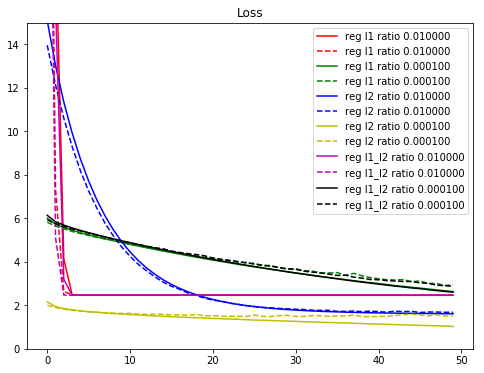

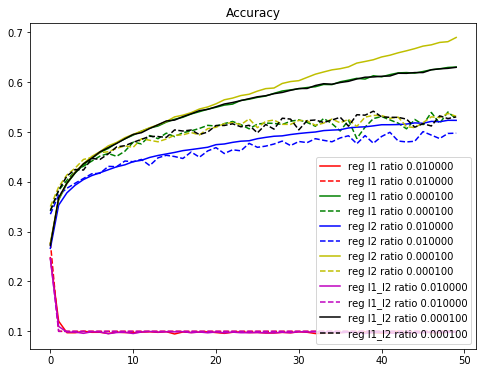

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
color_bar = ['r', 'g', 'b', 'y', 'm', 'k', 'C0', 'C1', 'C2']

plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_loss'])), results[cond]['train_loss'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_loss'])), results[cond]['valid_loss'], '--', color=color_bar[i], label=cond)
plt.title('Loss')
plt.ylim([0, 15])
plt.legend()
plt.show()
    
plt.figure(figsize=(8, 6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train_acc'])), results[cond]['train_acc'], '-', color=color_bar[i], label=cond)
    plt.plot(range(len(results[cond]['valid_acc'])), results[cond]['valid_acc'], '--', color=color_bar[i], label=cond)
plt.title('Accuracy')
plt.legend()
plt.show()